,E,N_i
0,39.346934,41
1,23.865122,19
2,14.474928,16
3,11.773094,13
4,5.561216,9
5,3.867807,2


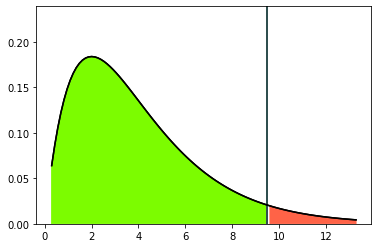

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
class ChiSquared:
    class SimpleNormal:
        def __init__(self, bins, data, alpha, degree):
            self.bins = bins
            self.data = data
            self.alpha = alpha
            self.degree = degree

        def get_normal_paramteres(self, array):
            array = np.array(array)
            mu = np.mean(array)
            sigma = ((1/(np.size(array)-1))*np.sum((array-mu)**2))**0.5
            return (mu,sigma)

        def get_log_normal_paramaters(self, array):
            array = np.array(array)
            mu,sigma = self.get_normal_paramteres(array)
            shape_paramter = (np.log(1+(sigma/mu)**2))**0.5
            lambda_parameter = np.log(mu)-0.5*(shape_paramter**2)
            return (shape_paramter,lambda_parameter)

        def normal_theoritical_frequency(self, array,bins):
            bins = np.array(bins)
            array = np.array(array)
            mu,sigma = self.get_normal_paramteres(array)
            dist = norm(mu,sigma)
            theroriticals = []
            for index,value in enumerate(bins):
                if(index == 0):
                    theroriticals.append(dist.cdf(value)*np.size(array))
                elif(index == np.size(bins)-1):
                    value2 = bins[index-1]
                    theroriticals.append(dist.cdf(value)*np.size(array)-dist.cdf(value2)*np.size(array))
                    theroriticals.append((1 - dist.cdf(value))*np.size(array))
                else:
                    value2 = bins[index-1]
                    theroriticals.append(dist.cdf(value)*np.size(array)-dist.cdf(value2)*np.size(array))
            return theroriticals

        def lognorm_cdf(self, lambda_parameter, shape_paramter, x, size):
            a = (np.log(x)-lambda_parameter)/shape_paramter
            return norm(0,1).cdf(a)*size

        def log_normal_theoritical_frequency(self, array, bins):
            bins = np.array(bins)
            array = np.array(array)
            shape_paramter,lambda_parameter = self.get_log_normal_paramaters(array)
            theroriticals = []
            array_size = np.size(array)
            for index,value in enumerate(bins):
                if(index == 0):
                    theroriticals.append(self.lognorm_cdf(lambda_parameter,shape_paramter,value,array_size))
                elif(index == np.size(bins)-1):
                    value2 = bins[index-1]
                    theroriticals.append(self.lognorm_cdf(lambda_parameter,shape_paramter,value,array_size)-self.lognorm_cdf(lambda_parameter,shape_paramter,value2,array_size))
                    theroriticals.append((1*array_size - self.lognorm_cdf(lambda_parameter,shape_paramter,value,array_size)))
                else:
                    value2 = bins[index-1]
                    theroriticals.append(self.lognorm_cdf(lambda_parameter,shape_paramter,value,array_size)-self.lognorm_cdf(lambda_parameter,shape_paramter,value2,array_size))
            return theroriticals

        def get_coditioned_sized(self, array, condition):
            dataframe = pd.DataFrame(data = {"data_values":array})
            return len(list((dataframe[condition].to_dict()['data_values']).values()))

        def observed_array(self):
            bins = np.array(self.bins)
            array = np.array(self.data)
            observeds = []
            array_size = np.size(array)
            dataframe = pd.DataFrame(data={"data_values":array})
            for index,value in enumerate(bins):
                if(index == 0):
                    condition = dataframe["data_values"]<=value
                    observeds.append((self.get_coditioned_sized(array,condition)))
                elif(index == np.size(bins)-1):
                    value2 = bins[index-1]
                    condition = (dataframe["data_values"]<=value) & (dataframe["data_values"]>value2)
                    observeds.append(self.get_coditioned_sized(array,condition))
                    condition = (dataframe["data_values"]>=value)
                    observeds.append(self.get_coditioned_sized(array,condition))
                else:
                    value2 = bins[index-1]
                    condition = (dataframe["data_values"]<=value) & (dataframe["data_values"]>value2)
                    observeds.append(self.get_coditioned_sized(array,condition))
            return observeds

        def bins_to_string(self, bins):
            bins = np.array(bins)
            string_bins = [] 
            for index,bin in enumerate(bins):
                if(index == 0):
                    string_bins.append("< " + str(bin))
                elif(index == np.size(bins)-1):
                    bin2 = bins[index-1]
                    string_bins.append(str(bin2) + " - " + str(bin))
                    string_bins.append(str(bin) + " >")
                else:
                    bin2 = bins[index-1]
                    string_bins.append(str(bin2) + " - " + str(bin))
            return string_bins

        def make_dataframe(self, array, bins):
            observeds = self.observed_array()
            theo_log_normal = self.log_normal_theoritical_frequency(array,bins)
            theo_normal = self.normal_theoritical_frequency(array,bins)
            string_bins = self.bins_to_string(bins)
            
            dataframe = pd.DataFrame(data = {"Interval" : string_bins ,
                                            "Observed Frequency" : observeds ,
                                            "Normal Theoritical" : theo_normal , 
                                            "Log-Normal Theoritical" : theo_log_normal})
            dataframe["Chi Normal"] = (dataframe["Observed Frequency"]-dataframe["Normal Theoritical"])**2/dataframe["Normal Theoritical"]
            dataframe["Chi Log-Normal"] = (dataframe["Observed Frequency"]-dataframe["Log-Normal Theoritical"])**2/dataframe["Log-Normal Theoritical"]
            return dataframe

        def check_chi_square(self): 
            self.data = np.array(self.data)
            limit_x_2 = chi2.ppf(1-self.alpha , self.degree)
            dataframe = self.make_dataframe(self.data , self.bins)
            chi_log_nor = dataframe['Chi Log-Normal'].sum()
            chi_nor = dataframe['Chi Normal'].sum()
            answer = ""
            if chi_nor < limit_x_2:
                answer += "Normal : can't say anything\n"
            else:
                answer += "Normal : crossed limit\n"
            if chi_log_nor < limit_x_2:
                answer += "Log Normal : can't say anything\n"
            else:
                answer += "Log Normal : crossed limit\n"
                
            return_dict = {"Chi Log" : chi_log_nor , "Chi Nor" : chi_nor , "X2 Limit" : limit_x_2}
            x = np.linspace(chi2.ppf(0.01, self.degree), chi2.ppf(0.99, self.degree), 100)
            rv = chi2(self.degree)
            y = rv.pdf(x)
            x_before, y_before = x[np.where(x < limit_x_2)], y[np.where(x < limit_x_2)]
            x_before, y_before = list(x_before), list(y_before)

            x_before.insert(0, x_before[0])
            y_before.insert(0, 0)
            x_before.append(x_before[-1])
            y_before.append(0)

            plt.ylim(0, max(y)*1.3)

            
            plt.fill(x_before, y_before, color="lawngreen")
            plt.plot(x, y, 'k-')
            plt.vlines(x= limit_x_2, ymin = 0, ymax = 1, color="darkslategray", lw=2)

            x_after, y_after = x[np.where(x > limit_x_2)], y[np.where(x > limit_x_2)]
            x_after, y_after = list(x_after), list(y_after)

            x_after.insert(0, x_after[0])
            y_after.insert(0, 0)
            x_after.append(x_after[-1])
            y_after.append(0)

            plt.ylim(0, max(y)*1.3)

            
            plt.fill(x_after, y_after, color="tomato")
            plt.plot(x, y, 'k-')

            return (return_dict , answer)

    class ComplexChiSquared:

        def __init__(self, bins, discrete_data, function=None):
            self.function = function
            self.bins = bins
            self.discrete_data = discrete_data
            self.dataframe_dict = {}
        
        def set_function(self, function):
            self.function = function

        def find_mean(self):
            summation = 0
            for index in range(len(self.bins) - 1):
                middle = (self.bins[index+1] + self.bins[index])/2
                summation += (middle) * self.discrete_data[index]
            return summation/np.sum(self.discrete_data)
        
        def find_e(self):
            self.dataframe_dict["E"] = []
            self.dataframe_dict["N_i"] = [] 
            for index in range(len(self.bins) - 1):
                p_lower_bound = self.function(self.bins[index])
                p_upper_bound = self.function(self.bins[index + 1])
                self.dataframe_dict["E"].append((p_upper_bound - p_lower_bound) * np.sum(self.discrete_data))
                self.dataframe_dict["N_i"].append(self.discrete_data[index])
            return self.dataframe_dict
        
        def set_alpha(self, alpha):
            self.alpha = alpha

        def set_freedom_degree(self, degree):
            self.degree = degree
        
        def set_df_alpha(self, alpha, degree):
            self.alpha = alpha
            self.degree = degree

        def find_chi(self):
            chis = (np.array(self.dataframe_dict["N_i"]) - np.array(self.dataframe_dict["E"]))**2/np.array(self.dataframe_dict["E"])
            
            limit_x_2 = chi2.ppf(1-self.alpha , self.degree)

            self.summation_chi = np.sum(chis)
            self.dataframe = pd.DataFrame(data=self.dataframe_dict)
            
            x = np.linspace(chi2.ppf(0.01, self.degree), chi2.ppf(0.99, self.degree), 100)
            rv = chi2(self.degree)
            y = rv.pdf(x)
            x_before, y_before = x[np.where(x < limit_x_2)], y[np.where(x < limit_x_2)]
            x_before, y_before = list(x_before), list(y_before)

            x_before.insert(0, x_before[0])
            y_before.insert(0, 0)
            x_before.append(x_before[-1])
            y_before.append(0)

            plt.ylim(0, max(y)*1.3)

            
            plt.fill(x_before, y_before, color="lawngreen")
            plt.plot(x, y, 'k-')
            plt.vlines(x= limit_x_2, ymin = 0, ymax = 1, color="darkslategray", lw=2)

            x_after, y_after = x[np.where(x > limit_x_2)], y[np.where(x > limit_x_2)]
            x_after, y_after = list(x_after), list(y_after)

            x_after.insert(0, x_after[0])
            y_after.insert(0, 0)
            x_after.append(x_after[-1])
            y_after.append(0)

            plt.ylim(0, max(y)*1.3)

            
            plt.fill(x_after, y_after, color="tomato")
            plt.plot(x, y, 'k-')
            
            display(self.dataframe)
            



# data = pd.read_csv("../sample_data.csv")
# sixty_years_data = list(data['data'].values)
# bins = [30,34,38,42,46,50,54]    
# chi = ChiSquared.SimpleNormal(bins , sixty_years_data , 0.05,5)
# chi.check_chi_square()
bins = [0, 20, 40, 60, 90, 120, 180]
discrete_data = [41, 19, 16, 13, 9, 2] 
chi = ChiSquared.ComplexChiSquared(bins, discrete_data)
mean = chi.find_mean()

def my_func(x):
    return (1 - np.exp((-1/mean)*x))

chi.set_function(my_func)
chi.find_e()
chi.set_df_alpha(0.05, 4)
chi.find_chi()

In [22]:
def f(x):
    return x**2
def b(fa, x):
    return fa(x)
b(f, 5)

25